<a href="https://colab.research.google.com/github/Bharathkumar1404/data-science-final-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTIALIZING THE LIBRARIES

In [192]:
#Initializing the matplotlib library
!pip install matplotlib

In [193]:
#Intializing the pmdarima library
!pip install pmdarima

In [194]:
#Initializing the prophet model library
!pip install prophet

In [195]:
#Initializing the statsmodels library
!pip install statsmodels

IMPORTING THE REQURIED LIBRARIES

In [196]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [197]:
# Importing the dataset using pandas' read_csv() function.
weather_data = pd.read_csv('pune.csv')
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-12-11 00:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,10,31,72,0.0,1013,18,10,114,5,pune
1,2008-12-11 01:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,9,30,72,0.0,1013,19,10,125,4,pune
2,2008-12-11 02:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,136,4,pune
3,2008-12-11 03:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,147,4,pune
4,2008-12-11 04:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,7,23,68,0.0,1014,20,10,136,4,pune


In [198]:
# Dropping irrelevant columns from the weather_data DataFrame
wf = weather_data.drop(columns=['DewPointC','cloudcover','moonrise', 'moonset', 'sunrise', 'sunset','sunHour','totalSnow_cm','uvIndex','moon_illumination','visibility','winddirDegree','windspeedKmph'])
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location
0,2008-12-11 00:00:00,30,18,18,18,18,10,72,0.0,1013,18,pune
1,2008-12-11 01:00:00,30,18,19,19,19,9,72,0.0,1013,19,pune
2,2008-12-11 02:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
3,2008-12-11 03:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
4,2008-12-11 04:00:00,30,18,20,20,20,7,68,0.0,1014,20,pune


In [199]:
# Converting 'date_time' to datetime format and extracting year, month, day, and hour; filtering data for years between 2009 and 2021.
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['year'] = wf['date_time'].dt.year
wf['month'] = wf['date_time'].dt.month
wf['day'] = wf['date_time'].dt.day
wf['hour'] = wf['date_time'].dt.hour

wf = wf[wf['year'] > 2008]
wf = wf[wf['year'] < 2022]

In [200]:
# Resetting the index of the DataFrame and dropping the old index to ensure sequential indexing.
wf = wf.reset_index(drop= True)

In [201]:
# Displaying a concise summary of the DataFrame, including column names, non-null counts, and data types.
print(wf.info())

# Displaying descriptive statistics for the numeric columns in the DataFrame, such as mean, std, min, and max values.
print(wf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     113952 non-null  datetime64[ns]
 1   maxtempC      113952 non-null  int64         
 2   mintempC      113952 non-null  int64         
 3   FeelsLikeC    113952 non-null  int64         
 4   HeatIndexC    113952 non-null  int64         
 5   WindChillC    113952 non-null  int64         
 6   WindGustKmph  113952 non-null  int64         
 7   humidity      113952 non-null  int64         
 8   precipMM      113952 non-null  float64       
 9   pressure      113952 non-null  int64         
 10  tempC         113952 non-null  int64         
 11  location      113952 non-null  object        
 12  year          113952 non-null  int32         
 13  month         113952 non-null  int32         
 14  day           113952 non-null  int32         
 15  hour          113

In [202]:
# Calculating the number of missing values in each column of the DataFrame.
missing_values = wf.isnull().sum()

# Printing the count of missing values for each column to identify data quality issues.
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date_time       0
maxtempC        0
mintempC        0
FeelsLikeC      0
HeatIndexC      0
WindChillC      0
WindGustKmph    0
humidity        0
precipMM        0
pressure        0
tempC           0
location        0
year            0
month           0
day             0
hour            0
dtype: int64


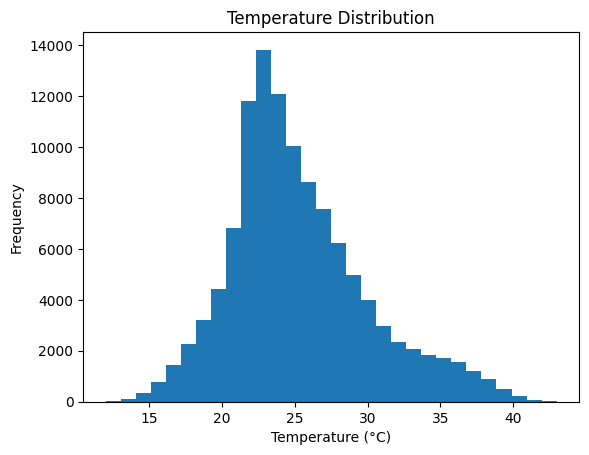

In [203]:
# Plotting a histogram to visualize the distribution of the 'tempC' column (temperature data).
wf['tempC'].plot(kind='hist', bins=30, title='Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()

year
2009    25.416210
2010    24.967808
2011    25.084817
2012    25.401753
2013    25.117009
2014    25.387100
2015    25.354566
2016    25.123634
2017    25.451027
2018    25.830023
2019    25.528311
2020    25.433629
2021    25.333219
Name: tempC, dtype: float64


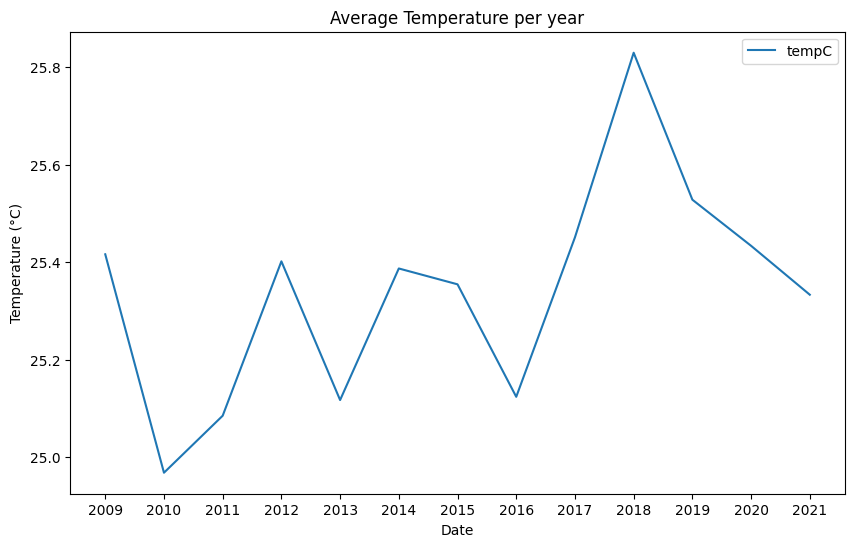

In [204]:
# Sorting the DataFrame by 'date_time' column
wf = wf.sort_values(by='date_time')

# Calculating the average temperature ('tempC') per year.
wfg = wf.groupby('year')['tempC'].mean()
print(wfg)

# Resetting the index for easier plotting and plotting a line graph of yearly average temperature.
wfg = wfg.reset_index()
wfg.plot(x='year', y='tempC', kind='line', figsize=(10, 6))

# Adding labels and title for the plot.
plt.xticks(wfg['year'].unique())
plt.title('Average Temperature per year')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


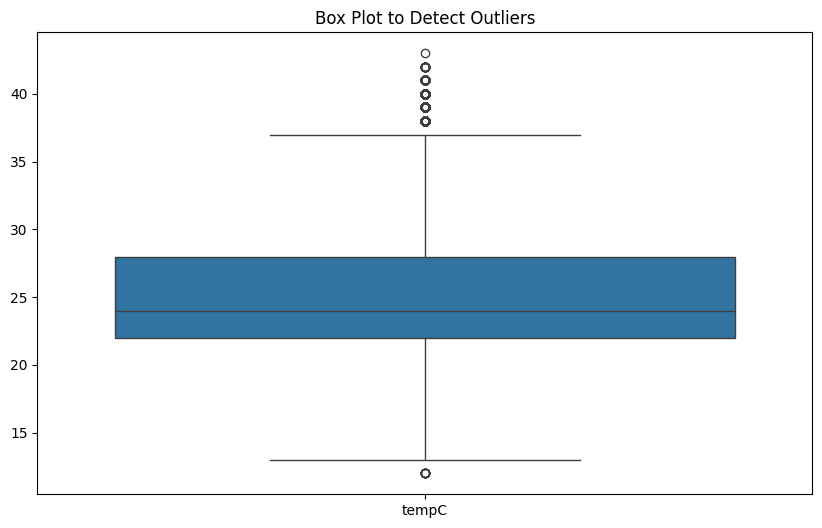

Number of outliers in Temperature: 1718
Original DataFrame shape: (113952, 16)
        year  tempC
1356    2009     38
1357    2009     38
1358    2009     38
1380    2009     38
1381    2009     38
...      ...    ...
107942  2021     39
107943  2021     39
107944  2021     39
107965  2021     38
107966  2021     38

[1718 rows x 2 columns]


In [205]:
# Plotting a boxplot for 'tempC' to visually detect outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=wf[['tempC']])
plt.title('Box Plot to Detect Outliers')
plt.show()

# Calculating IQR and identifying outliers in 'tempC'.
Q1 = wf['tempC'].quantile(0.25)
Q3 = wf['tempC'].quantile(0.75)
IQR = Q3 - Q1
outliers_tempC = wf[(wf['tempC'] < (Q1 - 1.5 * IQR)) | (wf['tempC'] > (Q3 + 1.5 * IQR))]

# Printing the number of outliers and details of outlier rows.
print("Number of outliers in Temperature:", len(outliers_tempC))
print("Original DataFrame shape:", wf.shape)
print(outliers_tempC[['year', 'tempC']])





Original DataFrame shape: (113952, 16)
DataFrame without outliers shape: (112234, 16)
Number of outliers in Temperature: 112234
            date_time  maxtempC  mintempC  FeelsLikeC  HeatIndexC  WindChillC  \
0 2009-01-01 00:00:00        31        17          17          17          17   
1 2009-01-01 01:00:00        31        17          17          17          17   
2 2009-01-01 02:00:00        31        17          17          17          17   
3 2009-01-01 03:00:00        31        17          17          17          17   
4 2009-01-01 04:00:00        31        17          17          17          17   

   WindGustKmph  humidity  precipMM  pressure  tempC location  year  month  \
0             7        50       0.0      1013     17     pune  2009      1   
1             9        46       0.0      1013     17     pune  2009      1   
2            10        43       0.0      1013     17     pune  2009      1   
3            12        40       0.0      1013     17     pune  2009      

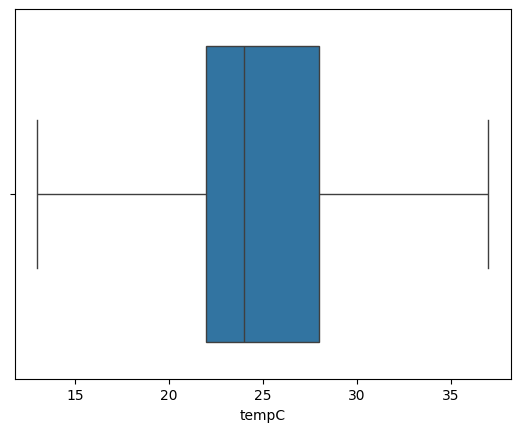

In [206]:
# Removing outliers from 'tempC' based on IQR thresholds and creating a new DataFrame.
wf_no_outliers = wf[(wf['tempC'] >= (Q1 - 1.5 * IQR)) & (wf['tempC'] <= (Q3 + 1.5 * IQR))]
wf_no_outliers.tail()

# Printing the shapes of the original and outlier-removed DataFrames for comparison.
print("Original DataFrame shape:", wf.shape)
print("DataFrame without outliers shape:", wf_no_outliers.shape)

# Plotting a boxplot of 'tempC' without outliers to confirm their removal.
sns.boxplot(x=wf_no_outliers['tempC'])

# Printing the number of rows in the outlier-free DataFrame and displaying the first few rows.
print("Number of outliers in Temperature:", len(wf_no_outliers))
print(wf_no_outliers.head())

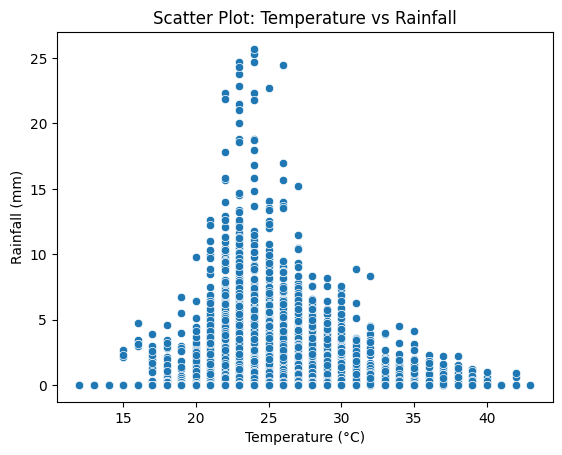

          tempC  precipMM
year                     
2009  25.416210  0.262340
2010  24.967808  0.269829
2011  25.084817  0.236416
2012  25.401753  0.155886
2013  25.117009  0.245959
2014  25.387100  0.207591
2015  25.354566  0.154749
2016  25.123634  0.259791
2017  25.451027  0.265982
2018  25.830023  0.188276
2019  25.528311  0.317146
2020  25.433629  0.302209
2021  25.333219  0.202489


In [207]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and rainfall ('precipMM').
sns.scatterplot(x='tempC', y='precipMM', data=wf)
plt.title('Scatter Plot: Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

# Calculating the yearly average for temperature ('tempC') and rainfall ('precipMM').
wfs =wf.groupby('year')[['tempC','precipMM']].mean()
print(wfs)


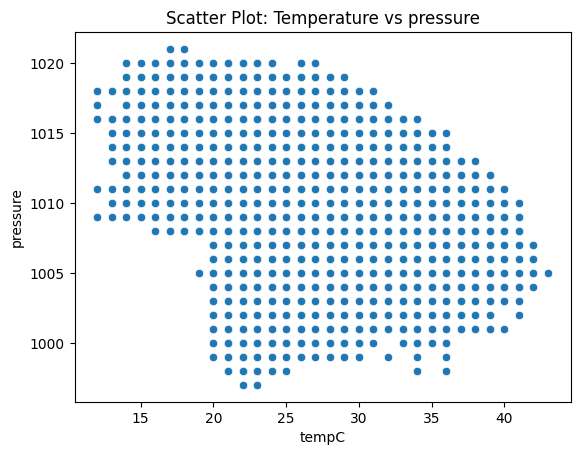

In [208]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and pressure.
sns.scatterplot(x='tempC', y='pressure', data=wf)
plt.title("Scatter Plot: Temperature vs pressure")
plt.show()


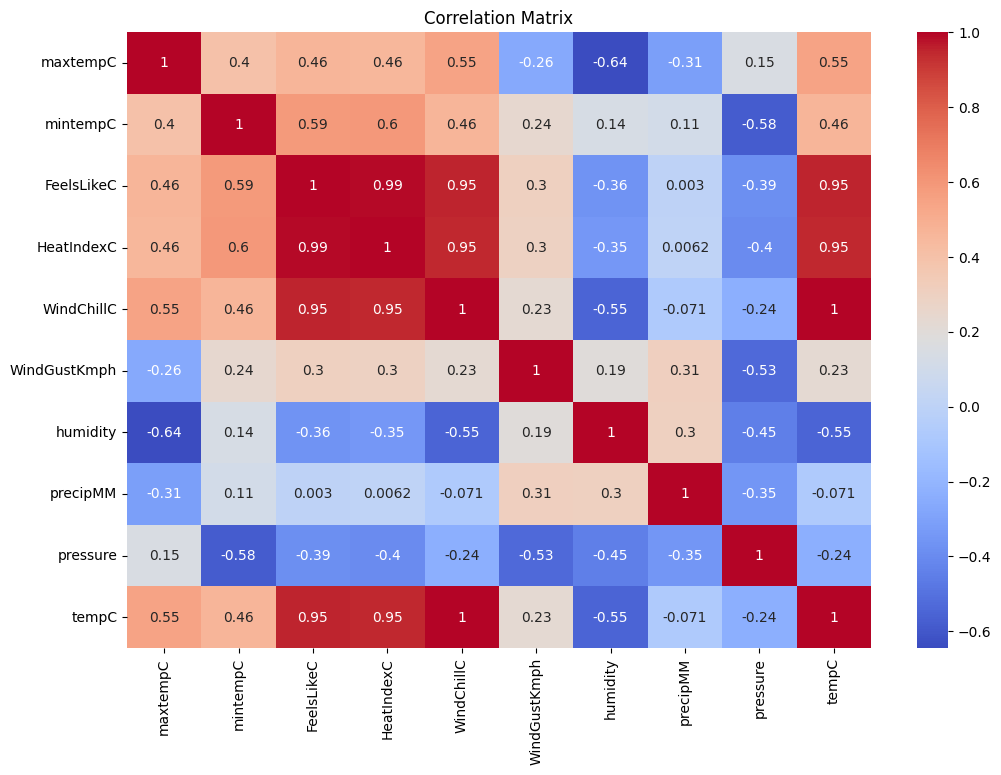

In [209]:
# Selecting only numeric columns from the DataFrame for correlation analysis.
numeric_data = wf.select_dtypes(include=['float64', 'int64'])

# Plotting a heatmap to visualize the correlation matrix of the numeric columns.
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [210]:
# Setting 'date_time' as the index and resampling data to daily averages for temperature, humidity, and pressure.
wf_no_outliers.set_index('date_time', inplace=True)
wf_daily_data = wf_no_outliers[['tempC', 'humidity', 'pressure']].resample('D').mean()

# Displaying the first 30 rows and the last few rows of the daily data.
print(wf_daily_data.head())
wf_daily_data.tail()

                tempC   humidity     pressure
date_time                                    
2009-01-01  22.541667  37.875000  1012.791667
2009-01-02  22.125000  44.000000  1013.750000
2009-01-03  22.583333  47.791667  1014.708333
2009-01-04  22.208333  52.791667  1013.583333
2009-01-05  22.458333  51.833333  1011.791667


,tempC,humidity,pressure
date_time,,,
2021-12-27,23.083333,44.208333,1014.708333
2021-12-28,22.833333,53.500000,1013.750000
2021-12-29,21.250000,53.333333,1014.083333
2021-12-30,21.250000,54.458333,1015.666667
2021-12-31,22.625000,48.416667,1016.333333


In [211]:
# # Converting 'tempC', 'humidity', and 'pressure' columns to integers and printing the updated data types.
wf_daily_data['tempC'] = wf_daily_data['tempC'].astype(int)
wf_daily_data['humidity'] = wf_daily_data['humidity'].astype(int)
wf_daily_data['pressure'] = wf_daily_data['pressure'].astype(int)
# print data types
print(wf_daily_data.dtypes)

tempC       int64
humidity    int64
pressure    int64
dtype: object


In [212]:
# Saving the daily resampled data to a CSV file named 'out.csv' without including the index.
wf_daily_data.to_csv('out.csv', index=False)

preprocessing

In [213]:
# Scaling 'tempC', 'humidity', and 'pressure' columns to a 0-1 range using MinMaxScaler.
scaler = MinMaxScaler()
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])

# Creating lag features for 'tempC' and 'humidity' to capture temporal relationships.
wf_daily_data['temp_lag_1'] = wf_daily_data['tempC'].shift(1)
wf_daily_data['humidity_lag_1'] = wf_daily_data['humidity'].shift(1)
print(wf_daily_data.head())

# Backfilling missing values caused by lagging.
wf_daily_data.fillna(method = 'bfill',inplace=True)
wf_daily_data.head()

# Splitting the data into training (before 2019) and testing (after 2019) sets.
train = wf_daily_data[wf_daily_data.index <= pd.to_datetime('2019-01-01')]
test = wf_daily_data[wf_daily_data.index > pd.to_datetime('2019-01-01')]


               tempC  humidity  pressure  temp_lag_1  humidity_lag_1
date_time                                                           
2009-01-01  0.307692  0.306818      0.70         NaN             NaN
2009-01-02  0.307692  0.386364      0.75    0.307692        0.306818
2009-01-03  0.307692  0.420455      0.80    0.307692        0.386364
2009-01-04  0.307692  0.477273      0.75    0.307692        0.420455
2009-01-05  0.307692  0.465909      0.65    0.307692        0.477273


<ipython-input-213-8b23aa6267ee>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wf_daily_data.fillna(method = 'bfill',inplace=True)


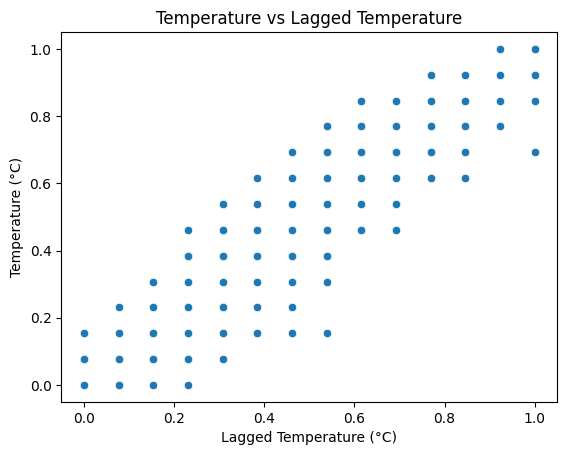

In [214]:
# Scatter plot for lagged features
sns.scatterplot(x=wf_daily_data['temp_lag_1'], y=wf_daily_data['tempC'])
plt.title("Temperature vs Lagged Temperature")
plt.xlabel("Lagged Temperature (°C)")
plt.ylabel("Temperature (°C)")
plt.show()


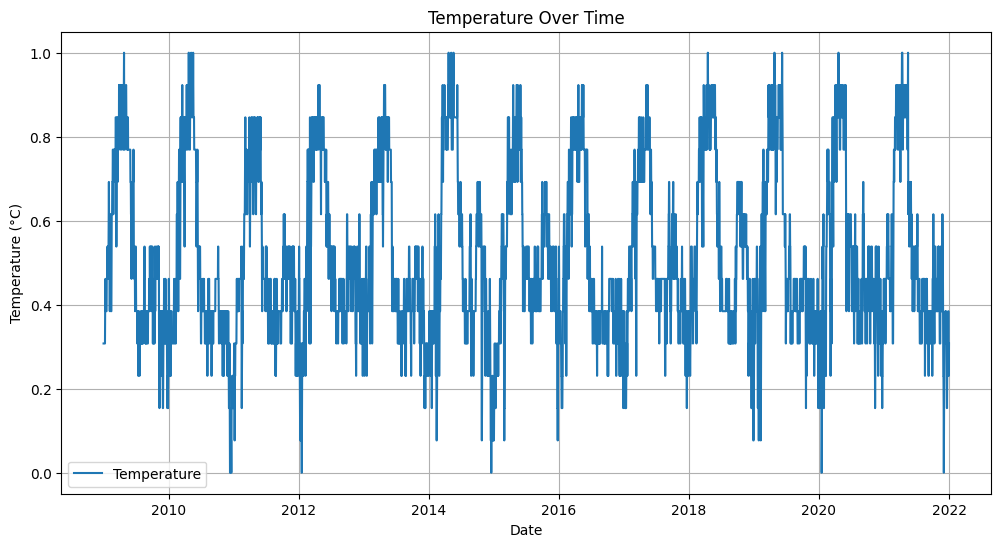

In [215]:
# Plotting temperature trends over time of original data.
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index,wf_daily_data['tempC'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


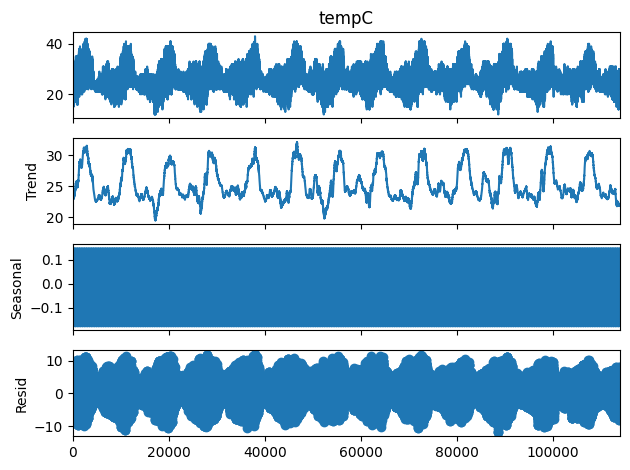

In [216]:
# Performing seasonal decomposition of temperature ('tempC') to analyze trends, seasonality, and residuals.
result = seasonal_decompose(wf['tempC'], model='additive', period=365)
result.plot()
plt.show()

ARIMA MODEL

In [217]:
# Function to check stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.
def check_stationarity(series):
    """
    Check the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - series: pandas Series
        The time series to be tested for stationarity.

    Returns:
    - None: Prints the ADF statistic, p-value, and stationarity status.

    Key Steps:
    1. Perform the ADF test on the input series after removing NaN values.
    2. Print the ADF test statistic and the p-value.
    3. Determine stationarity based on the p-value:
       - If p-value < 0.05: The series is stationary.
       - Otherwise: The series is not stationary.
    """
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

# Checking stationarity of the 'tempC' column.
check_stationarity(wf['tempC'])

ADF Statistic: -8.60181633817182
p-value: 6.836621222378553e-14
The series is stationary.


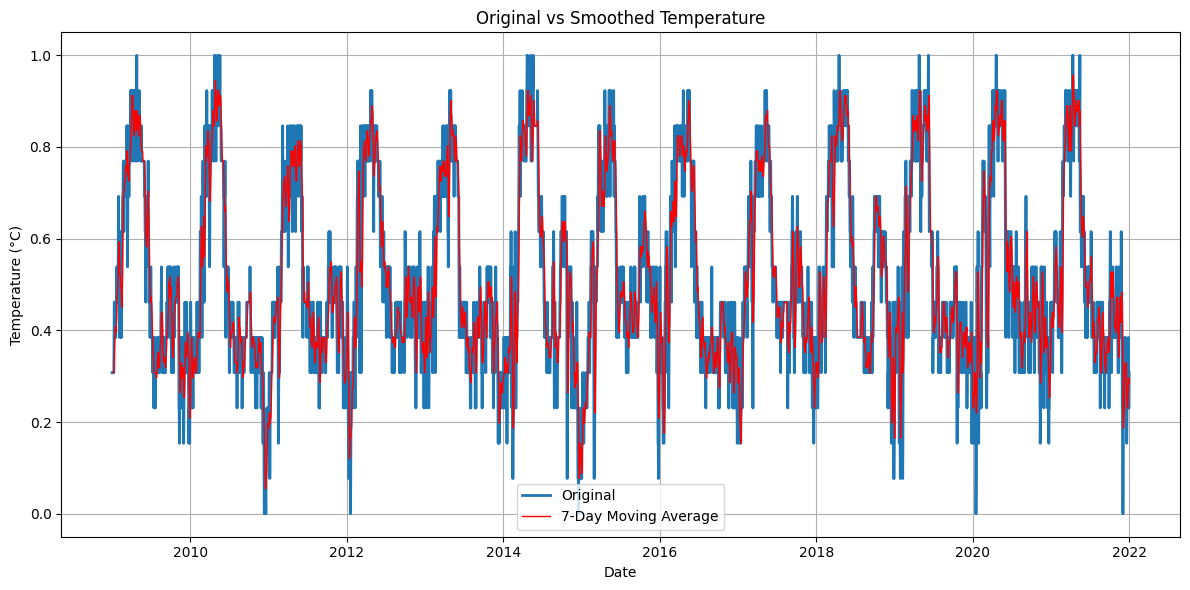

In [218]:
#Calculating a 7-day moving average for 'tempC' to to smooth the temperatue data
temperature_rolling = wf_daily_data['tempC'].rolling(window=7).mean()

#Plotting the original temperature data and the 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index, wf_daily_data['tempC'], label='Original', linewidth=2)
plt.plot(wf_daily_data.index, temperature_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




<Figure size 1200x600 with 0 Axes>

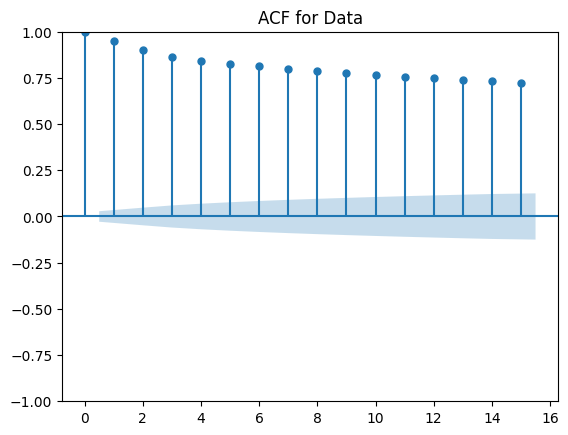

<Figure size 1200x600 with 0 Axes>

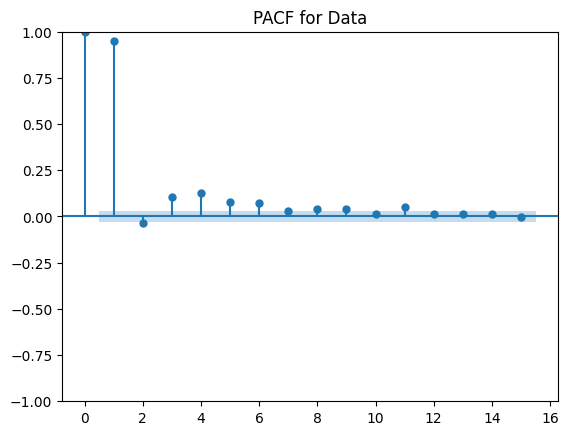

In [219]:
#Plotting the ACF to analyze lag dependencies in the data
plt.figure(figsize=(12, 6))
plot_acf(wf_daily_data['tempC'], lags=15)
plt.title('ACF for Data')
plt.show()

#Plotting the PACF to analyze direct correlations with lagged data
plt.figure(figsize=(12, 6))
plot_pacf(wf_daily_data['tempC'], lags=15)
plt.title('PACF for Data')
plt.show()

In [220]:
#Using auto-arima to automatically find the best ARIMA model for the training data('tempC')
#It searches through various combinations of p, d & q parameters basec on AIC(Akaike Information Criterion)
auto_model = auto_arima(train['tempC'],
                        start_p=0, start_q=0, #Starting values for p and q
                        max_p=5, max_q=5, #Maximum values for p and q
                        d=None, #Automatically determine the differencing oredr
                        seasonal=False, #Non-seasonal Arima model
                        stepwise=True, #Stepwise search to speedup the process
                        trace=True, #Display progress during model selection
                        error_action='ignore', #Ignore erorrs during the search
                        suppress_warnings=True, #Suppress waring messages
                        max_order=None, #NO limit on the sum of p and q
                        information_criterion='aic' #Use AIC to choose the best model
                        )

#Printing a summary of the selected ARiMA model
print(auto_model.summary())


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6027.736, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1503.837, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10039.722, Time=1.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=10.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10132.545, Time=0.62 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1784.926, Time=0.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10238.321, Time=1.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3817.682, Time=1.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10261.911, Time=5.63 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10259.752, Time=5.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-10259.471, Time=2.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-10255.638, Time=2.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=8.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-10258.230, Time=4.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-10264.282, Time=10.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-10263.234, Time=9.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10269.723, Time=6.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-10176.370, Time=5.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-10120.884, Time=7.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-10264.201, Time=9.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10116.397, Time=2.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-10260.866, Time=6.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-10260.697, Time=11.57 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 119.598 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(2, 0, 2)   Log Likelihood                5140.862
Date:                Sun, 05 Jan 2025   AIC                         -10269.723
Time:                        21:46:50   BIC                         -10232.503
Sample:                    01-01-2009   HQIC                        -10256.469
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0036      0.001      3.488      0.000       0

In [221]:
#Building an ARIMA model with order (2, 0, 2) and including exogenous variables
model = ARIMA(train['tempC'], order=(2, 0, 2),exog=train[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
model_fit = model.fit()

#Printing the summary of the fitted ARIMA model
print(model_fit.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  tempC   No. Observations:                 3653
Model:                 ARIMA(2, 0, 2)   Log Likelihood                5386.873
Date:                Sun, 05 Jan 2025   AIC                         -10753.746
Time:                        21:47:16   BIC                         -10691.713
Sample:                    01-01-2009   HQIC                        -10731.655
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0252      0.007      3.777      0.000       0.012       0.038
humidity          -0.3357      0.012    -28.996      0.000      -0.358      -0.313
pressure          -0.0119      0.005

In [222]:
#Forecasting  for the test period using the fitted model and exogenous variables
forecast_steps_1 = len(test)
long_term_forecast = model_fit.get_forecast(steps=forecast_steps_1,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
long_term_forecast_mean = long_term_forecast.predicted_mean
conf_int_1= long_term_forecast.conf_int(alpha = 0.68)

# Extract lower and upper bounds
lower_bound_1 = conf_int_1.iloc[:, 0]
upper_bound_1 = conf_int_1.iloc[:, 1]

forecast_index_1 = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps_1, freq='D')

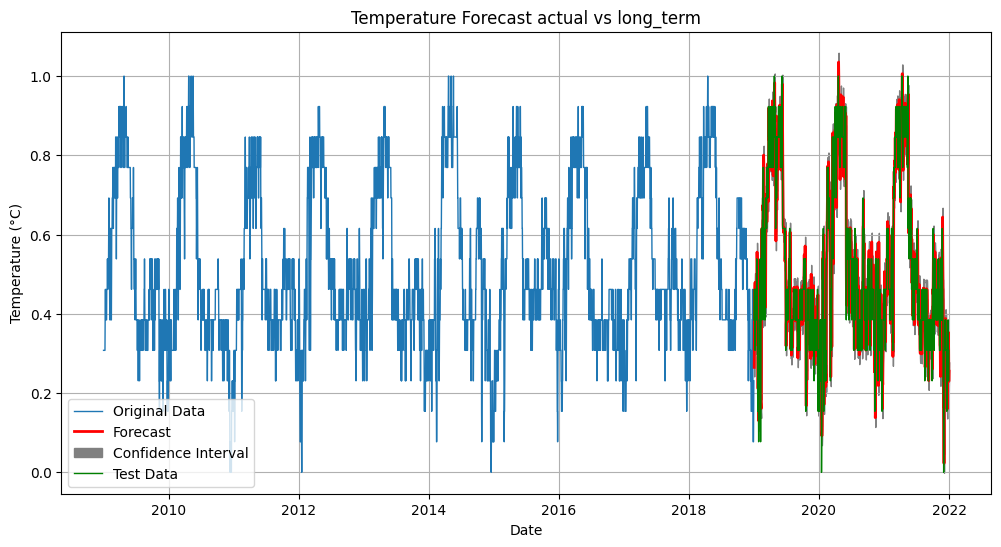

,predicted_mean
2019-01-02,0.264702
2019-01-03,0.383937
2019-01-04,0.458625
2019-01-05,0.441945
2019-01-06,0.460163
...,...
2021-12-27,0.300252
2021-12-28,0.352943
2021-12-29,0.309205
2021-12-30,0.229187


In [223]:
#Plotting the origonal training data, forecasted values, and actual test adata for comparsion
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index_1, long_term_forecast.predicted_mean, label='Forecast', color='red', linewidth=2)
plt.fill_between(forecast_index_1, lower_bound_1, upper_bound_1, color='gray', label='Confidence Interval')
plt.plot(test.index, test['tempC'], label='Test Data', color='green', linewidth=1)
plt.title('Temperature Forecast actual vs long_term')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

#Displaying the forecasted values
long_term_forecast.predicted_mean


In [224]:
forecast_steps_2 = 7
short_term_forecast = model_fit.get_forecast(steps=forecast_steps_2,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']][:forecast_steps_2])
short_term_forecast_mean = short_term_forecast.predicted_mean
conf_int_2 = short_term_forecast.conf_int(alpha = 0.68)
#Extract lower and upper bounds
lower_bound_2 = conf_int_2.iloc[:, 0]
upper_bound_2 = conf_int_2.iloc[:, 1]

#Creating a date range for the forecasted values to align with the test set
forecast_index_2 = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps_2, freq='D')


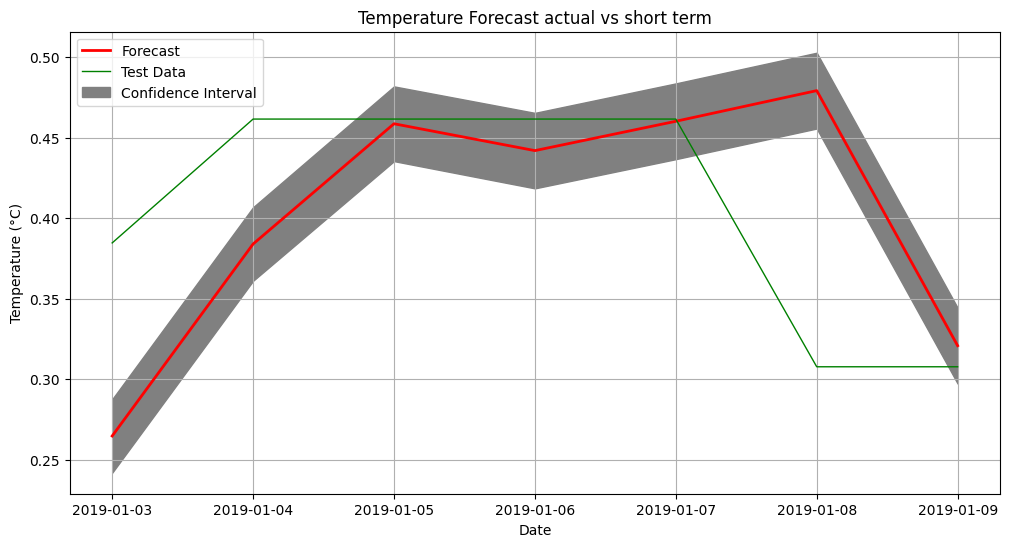

In [225]:
#Plotting the origonal training data, short_term_forecast values, and actual test adata for comparsion
plt.figure(figsize=(12, 6))
#plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index_2, short_term_forecast.predicted_mean, label='Forecast', color='red', linewidth=2)
plt.plot(test.index[1:8], test['tempC'][:forecast_steps_2], label='Test Data', color='green', linewidth=1)
plt.fill_between(forecast_index_2, lower_bound_2, upper_bound_2, color='gray', label='Confidence Interval')
plt.title('Temperature Forecast actual vs short term')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

#Displaying the forecasted values
short_term_forecast


In [235]:
print(long_term_forecast.predicted_mean)
#Calculating and printing thr evalution metrics for the forecast: MAE, RMSE, R^2
mae = mean_absolute_error(test['tempC'], long_term_forecast.predicted_mean)
print("MAE:", mae)# Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test['tempC'], long_term_forecast.predicted_mean))
print("RMSE:", rmse)# Root Mean Squared Error
r2 = r2_score(test['tempC'], long_term_forecast.predicted_mean)
print("R²:", r2)# Coefficient of Determination


2019-01-02    0.264702
2019-01-03    0.383937
2019-01-04    0.458625
2019-01-05    0.441945
2019-01-06    0.460163
                ...   
2021-12-27    0.300252
2021-12-28    0.352943
2021-12-29    0.309205
2021-12-30    0.229187
2021-12-31    0.255090
Freq: D, Name: predicted_mean, Length: 1095, dtype: float64
MAE: 0.046748429841852
RMSE: 0.06321175440368819
R²: 0.9059778209296673


In [236]:
print(short_term_forecast.predicted_mean)
#Calculating and printing thr evalution metrics for the short_term_forecast: MAE, RMSE, R^2
test_short = test[1:8]['tempC']
mae = mean_absolute_error(test_short, short_term_forecast.predicted_mean)
print("MAE:", mae)# Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test_short, short_term_forecast.predicted_mean))
print("RMSE:", rmse)# Root Mean Squared Error
r2 = r2_score(test_short, short_term_forecast.predicted_mean)
print("R²:", r2)# Coefficient of Determination


2019-01-02    0.264702
2019-01-03    0.383937
2019-01-04    0.458625
2019-01-05    0.441945
2019-01-06    0.460163
2019-01-07    0.479206
2019-01-08    0.320787
Freq: D, Name: predicted_mean, dtype: float64
MAE: 0.09782234660712359
RMSE: 0.12065121809793217
R²: -2.172214966961347


FACEBOOK PROPHET MODEL

In [227]:
# Creating a new DataFrame from thr training data and removing the lag columns
wf_pro = pd.DataFrame(train)
wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'],inplace = True)
# Adding a 'ds' column with datetime from the ndex and a 'y' column with the target variable('tempC')
wf_pro['ds'] = pd.to_datetime(train.index)
wf_pro['y'] = train['tempC']

# Displaying the first few steps of the processed DataFrame
wf_pro.head()

,tempC,humidity,pressure,ds,y
date_time,,,,,
2009-01-01,0.307692,0.306818,0.70,2009-01-01,0.307692
2009-01-02,0.307692,0.386364,0.75,2009-01-02,0.307692
2009-01-03,0.307692,0.420455,0.80,2009-01-03,0.307692
2009-01-04,0.307692,0.477273,0.75,2009-01-04,0.307692
2009-01-05,0.307692,0.465909,0.65,2009-01-05,0.307692


In [238]:
def prepare_prophet_data(train, test):
    """
    Prepares the training and test datasets for Prophet by creating 'ds' and 'y' columns
    and removing unnecessary lag columns.

    Parameters:
    - train: DataFrame containing the training data.
    - test: DataFrame containing the test data.

    Returns:
    - wf_pro: Processed training DataFrame with 'ds' and 'y' columns.
    - wf_pro_test: Processed test DataFrame with 'ds' and 'y' columns.
    """
    # Processing the train data
    wf_pro = pd.DataFrame(train)
    wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro['ds'] = pd.to_datetime(train.index)  # Adding 'ds' column with datetime
    wf_pro['y'] = train['tempC']  # Adding 'y' column with the target variable

    # Processing the test data
    wf_pro_test = pd.DataFrame(test)
    wf_pro_test.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro_test['ds'] = pd.to_datetime(test.index)  # Adding 'ds' column with datetime
    wf_pro_test['y'] = test['tempC']  # Adding 'y' column with the target variable

    # Returning the processed DataFrames
    return wf_pro, wf_pro_test


In [239]:
#calling the function to get the processed train and test dataset
wf_pro, wf_pro_test = prepare_prophet_data(train, test)

In [240]:
# Initializing and fitting the prophet model on the training data
model = Prophet(interval_width = 0.68)
model.fit(wf_pro)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8sl68sii/0he5r4am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8sl68sii/fuzqlx37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95221', 'data', 'file=/tmp/tmp8sl68sii/0he5r4am.json', 'init=/tmp/tmp8sl68sii/fuzqlx37.json', 'output', 'file=/tmp/tmp8sl68sii/prophet_modelblkgnvat/prophet_model-20250105215808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


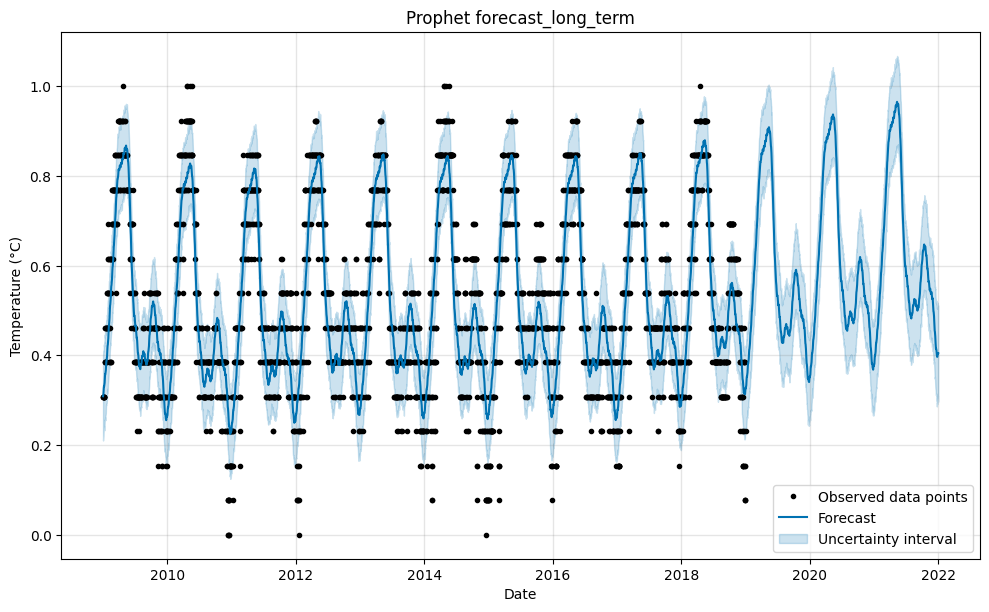

In [241]:

# Creating a future DataFrame for predictions, with the same frequency as the test data
forecast_pro_1=len(wf_pro_test)
future_long_term = model.make_future_dataframe(periods=forecast_pro_1,freq='D')

# Generating the predictions for the future dates
forecast_long_term = model.predict(future_long_term)

# Displaying the key columns of the forecast, including predicted values('yhat') and confidence intervals
forecast_long_term[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()

# Extracting true values and predictions for evaluation
y_true = wf_pro_test['y'].values  # Actual test values
y_pred = forecast_long_term['yhat'][-len(wf_pro_test):].values # Predicted values

#combining training and test data for visulization
wf_prophet = pd.concat([wf_pro,wf_pro_test])

#Plotting the Prophet forecast with observed data
prophet_plot_1 = model.plot(forecast_long_term, include_legend=True)
plt.title("Prophet forecast_long_term")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [242]:
# Creating a future DataFrame for predictions, with the same frequency as the test data
forecast_pro_2=7
future_short_term = model.make_future_dataframe(periods=forecast_pro_2,freq='D')

# Generating the predictions for the future dates
forecast_short_term = model.predict(future_short_term)

# Displaying the key columns of the forecast, including predicted values('yhat') and confidence intervals
forecast_short_term[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()

# Extracting true values and predictions for evaluation
y_true = wf_pro_test[1:8]['y'].values  # Actual test values
y_pred = forecast_short_term['yhat'][:forecast_pro_2].values # Predicted values

#combining training and test data for visulization
wf_prophet = pd.concat([wf_pro,wf_pro_test])


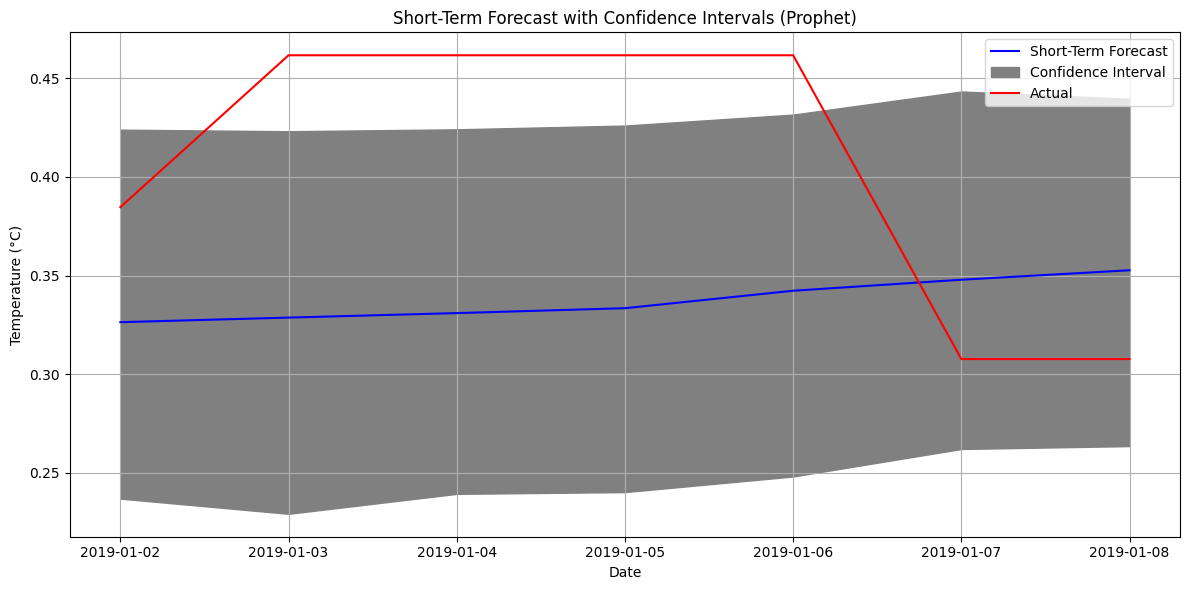

In [243]:

# Filter the forecasts for plotting
short_forecast = forecast_short_term[-short_term_days:]  # Only the last 7 days for short-term
#long_forecast = forecast_long_term[-long_term_days:]  # Only the last 365 days for long-term

# Plot Short-Term Forecast
plt.figure(figsize=(12, 6))
plt.plot(short_forecast['ds'], short_forecast['yhat'], label='Short-Term Forecast', color='blue')
plt.fill_between(
    short_forecast['ds'],
    short_forecast['yhat_lower'],
    short_forecast['yhat_upper'],
    color='gray', label='Confidence Interval'
)
plt.plot(wf_pro_test['ds'][:short_term_days], wf_pro_test['y'][:short_term_days], label='Actual', color='red')
plt.title('Short-Term Forecast with Confidence Intervals (Prophet)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


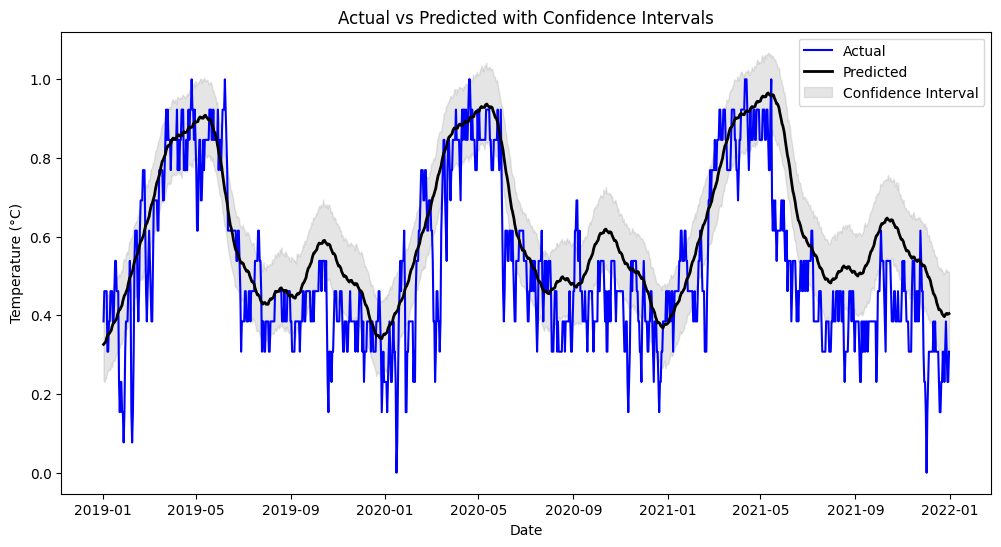

,yhat
0,0.308907
1,0.310593
2,0.312552
3,0.320928
4,0.326102
...,...
4743,0.403508
4744,0.405147
4745,0.402457
4746,0.403435


In [244]:
# Merge actual test data with the forecasted values, including the cinfindence intervals
forecast_actual = pd.merge(wf_pro_test, forecast_long_term[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Plot actual vs predicted values along with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(forecast_actual['ds'], forecast_actual['y'], label='Actual', color='blue')
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], label='Predicted', color='black',linewidth=2)
plt.fill_between(forecast_actual['ds'],
                 forecast_actual['yhat_lower'],
                 forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Displaying the predicted values ('yhat') from the forecast
forecast_long_term['yhat']

In [245]:
# Calculating and printing the performance metrics to evaluate the model
print("Mean Squared Error (MSE):", mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat'])))
print("R-squared (R²):", r2_score(y_true = wf_prophet["y"], y_pred = forecast['yhat']))


# Calculating and printing the performance metrics to evaluate the model
print("Mean Squared Error (MSE):", mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat'])))
print("R-squared (R²):", r2_score(y_true = wf_prophet["y"], y_pred = forecast['yhat']))



Mean Squared Error (MSE): 0.011477446767786083
Mean Absolute Error (MAE): 0.08179121184711043
Root Mean Squared Error (RMSE): 0.10713284635342274
R-squared (R²): 0.7181979238210471
Mean Squared Error (MSE): 0.011477446767786083
Mean Absolute Error (MAE): 0.08179121184711043
Root Mean Squared Error (RMSE): 0.10713284635342274
R-squared (R²): 0.7181979238210471


cnn_lstm

In [ ]:
# Function to create sequences of input feature and target valuess for the time series data
def sequence_creating(data,seq_len,target_col = 'tempC'):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)# Extracting feature sequences
    y.append(data.iloc[i+seq_len][target_col])# Extracting corresponding targets
  return np.array(X), np.array(y)

# Setting the sequence lenght for thr model and creatin train/test dataset
sequence_length = 90
X_train, y_train = sequence_creating(train,sequence_length)
X_test, y_test = sequence_creating(test,sequence_length)

# Printing the shapes of the input features and target arrays
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Building a CNN-LSTM model for time series prediction
model = Sequential()

# Convolution layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model.add(MaxPooling1D(pool_size=2)) # Max pooling layer

model.add(LSTM(100, activation='relu', return_sequences=False)) # LSTM layer

model.add(Flatten()) # Flattering the output

model.add(Dense(1)) # Dense layer for final output

# Compiling the modle with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Displaying the model summary
model.summary()

# Training the model on training data and validating on test data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predicting temperature values using the test data
y_pred = model.predict(X_test)

# Plotting actual vs predicted temperature values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()



In [ ]:
# Calculating and printing evaluation metric for the modles performance on the test dat
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
r2 = r2_score(y_test, y_pred) # Coefficient of Determination

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

TEMPORAL FUSION TRANSFORMER MODEL

ARIMA MODEL FOR MANSOON SEASON

In [ ]:
#wf.set_index('date_time', inplace=True)
#wf_seasons = wf[['precipMM','humidity','pressure']].resample('M').mean()
#wf_seasons.head()

In [ ]:
wf.set_index('date_time', inplace=True)
wf_season_month = wf[['year','month','precipMM','humidity','pressure']]
wf_season_month.head()

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return "summer"
    elif month in [6,7,8]:
        return "rainy"
    elif month in [9,10,11,]:
        return "spring"
    elif month in [12, 1, 2]:
        return "winter"
    else:
        return "Unknown"
#ipython-input-366-2d1aba2fb642


In [ ]:
wf_season_month['season'] = wf_season_month['month'].apply(get_season)
wf_season_month.tail()

In [ ]:
mansoon_data = wf_season_month[wf_season_month['season'] == 'rainy']
mansoon_data.head()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mansoon_data[['precipMM']])#, 'humidity']])
plt.title('Box Plot to Detect Outliers')
plt.show()

Q1 = mansoon_data['precipMM'].quantile(0.25)
Q3 = mansoon_data['precipMM'].quantile(0.75)
IQR = Q3 - Q1

#Q5 = wf['humidity'].quantile(0.25)
#Q7 = wf['humidity'].quantile(0.75)
#IQR1 = Q7 - Q5

outliers_precipMM = mansoon_data[(mansoon_data['precipMM'] < (Q1 - 1.5 * IQR)) | (mansoon_data['precipMM'] > (Q3 + 1.5 * IQR))]

In [ ]:
print("Number of outliers in Temperature:", len(outliers_precipMM))

In [ ]:
print("Original DataFrame shape:", mansoon_data.shape)
print(outliers_precipMM[['year', 'precipMM']])

In [ ]:
wf_M= mansoon_data[(mansoon_data['precipMM'] >= (Q1 - 1.5 * IQR)) & (mansoon_data['precipMM'] <= (Q3 + 1.5 * IQR))]
wf_M.tail()

In [ ]:
sns.boxplot(x=wf_M['precipMM'])
print("Number of outliers in Temperature:", len(wf_M))
wf_M.head()


In [ ]:
wf_M.head()

In [ ]:
wf_mansoon = wf_M[['precipMM','humidity','pressure']].resample('D').mean()
wf_mansoon.head()

In [ ]:
# Scale the selected columns and store the result in a temporary variable
scaled_data = scaler.fit_transform(wf_mansoon[['precipMM','humidity','pressure']])

# Assign the scaled values back to the original columns
wf_mansoon[['precipMM','humidity','pressure']] = scaled_data

In [ ]:
wf_mansoon['precipMM_lag_1'] = wf_mansoon['precipMM'].shift(1)
wf_mansoon['humidity_lag_1'] = wf_mansoon['humidity'].shift(1)

In [ ]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

In [ ]:
wf_mansoon.fillna(method = 'bfill',inplace=True)
wf_mansoon.head()

In [ ]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

In [ ]:
# Split into training and testing setstrain_size = int(len(wf_mansoon) * 0.8)  # 80% for training

#train_m = wf_mansoon.iloc[:train_size]
#test_m = wf_mansoon.iloc[train_size:]
train_m = wf_mansoon[wf_mansoon.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m = wf_mansoon[wf_mansoon.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
plt.figure(figsize=(10, 5))
plt.plot(wf_mansoon['precipMM'], label="Training Data", color="green")
#plt.plot(test_m['precipMM'], label="Validation Data", color="green")
#plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

In [ ]:

precipMM_result = seasonal_decompose(wf_mansoon['precipMM'], model='additive', period=365)
precipMM_result.plot()
plt.show()
check_stationarity(wf_mansoon['precipMM'])
precipMM_rolling = wf_mansoon['precipMM'].rolling(window=7).mean()
plt.figure(figsize=(12, 6))
plt.plot(wf_mansoon.index, wf_mansoon['precipMM'], label='Original', linewidth=2)
plt.plot(wf_mansoon.index, precipMM_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed precipMM')
plt.xlabel('Date')
plt.ylabel('precip')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(wf_mansoon['precipMM'], lags=15)
plt.title('ACF for Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(wf_mansoon['precipMM'], lags=15)
plt.title('PACF for Data')
plt.show()

In [ ]:

from pmdarima import auto_arima

auto_model = auto_arima(train_m['precipMM'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic'
                        )


print(auto_model.summary())

In [ ]:
m_model = ARIMA(train_m['precipMM'], order=(4, 0, 1),exog=train_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_model_fit = m_model.fit()
print(m_model_fit.summary())

In [ ]:
m_forecast_steps = len(test_m)
m_forecast = m_model_fit.forecast(steps=m_forecast_steps,exog=test_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_forecast_index = pd.date_range(start=test_m.index[0] + pd.Timedelta(days=1), periods=m_forecast_steps, freq='D')


In [ ]:


#outliers_humidity = wf[(wf['humidity'] < (Q5 - 1.5 * IQR)) | (wf['humidity'] > (Q7 + 1.5 * IQR))]

#print("Number of outliers in Humidity:", len(outliers_humidity))

#print(outliers_humidity[['year', 'humidity']])

plt.figure(figsize=(12, 6))
plt.plot(train_m.index, train_m['precipMM'], label='Original Data', linewidth=1)
plt.plot(m_forecast_index, m_forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test_m.index, test_m['precipMM'], label='Test Data', color='green', linewidth=1)
plt.title('precipMM Forecast')
plt.xlabel('Date')
plt.ylabel('precipMM')
plt.legend()
plt.grid()
plt.show()


In [ ]:
test_m.shape

In [ ]:
m_forecast.shape

In [ ]:

mae = mean_absolute_error(test_m['precipMM'], m_forecast)
print("MAE:", mae)
rmse = np.sqrt(mean_squared_error(test_m['precipMM'], m_forecast))
print("RMSE:", rmse)
r2 = r2_score(test_m['precipMM'], m_forecast)
print("R²:", r2)

prophet

In [ ]:
wf_mansoon_m = pd.DataFrame(wf_mansoon)
wf_mansoon_m.drop(columns=['precipMM_lag_1', 'humidity_lag_1'],inplace = True)
wf_mansoon_m.head()


In [ ]:
wf_mansoon_m['ds'] = pd.to_datetime(wf_mansoon_m.index)
wf_mansoon_m['y'] = wf_mansoon_m['precipMM']
wf_mansoon_m.head()

#train_size = int(len(wf_mansoon_m) * 0.8)  # 80% for training
#train_m = wf_mansoon_m.iloc[:train_size]
#test_m = wf_mansoon_m.iloc[train_size:]

train_m_p = wf_mansoon_m[wf_mansoon_m.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m_p = wf_mansoon_m[wf_mansoon_m.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object

In [ ]:
m_p_model = Prophet(interval_width = 0.68)
m_p_model.fit(train_m_p)

In [ ]:
m_p_forecast_steps=len(test_m_p)
m_p_future = m_p_model.make_future_dataframe(periods=forecast_steps,freq='D')

In [ ]:
m_p_forecast = m_p_model.predict(m_p_future)
m_p_forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()


In [ ]:
y_true = wf_mansoon_m['y'].values  # Replace 'y' with your target column name
y_pred = m_p_forecast['yhat'][:len(y_true)].values

In [ ]:
wf_prophet_m = pd.concat([train_m_p,test_m_p])

In [ ]:
prophet_plot_2 = m_p_model.plot(m_p_forecast, include_legend=True)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.show()

In [ ]:

# Merge actual and forecasted data
m_p_forecast_actual = pd.merge(test_m_p, m_p_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [ ]:


# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['y'], label='Actual', color='blue')
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['yhat'], label='Predicted', color='yellow',linewidth=2)
plt.fill_between(m_p_forecast_actual['ds'],
                 m_p_forecast_actual['yhat_lower'],
                 m_p_forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.legend()
plt.show()

m_p_forecast['yhat']

In [ ]:
# code
# Ensure y_pred has the same length as wf_prophet_m["y"]
y_pred_subset = m_p_forecast['yhat'][:len(wf_prophet_m["y"])]

In [ ]:
# code
print("Mean Squared Error (MSE):", mean_squared_error(y_true = y_true, y_pred = y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = y_true, y_pred = y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = y_true, y_pred = y_pred)))
print("R-squared (R²):", r2_score(y_true = y_true, y_pred = y_pred))

tunning

In [ ]:
# Import the necessary module
import itertools

In [ ]:
# Simplified hyperparameter grid
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "seasonality_prior_scale": [0.1, 1.0, 10.0],
}

# Update the function and grid search accordingly
# Remove holidays_prior_scale from function arguments
def evaluate_prophet(data, changepoint_prior_scale, seasonality_prior_scale):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(data)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    forecast_trimmed = forecast[:len(data)]
    error = mean_absolute_error(data['y'], forecast_trimmed['yhat'])
    return error

# Update all_params and perform grid search
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []
for params in all_params:
    error = evaluate_prophet(
        train_m_p,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"]
    )
    results.append((params, error))

best_params, best_error = min(results, key=lambda x: x[1])

print("Best Parameters:", best_params)
print("Best Error (MAE):", best_error)


In [ ]:
# Train the model with the best parameters
best_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
)
best_model.fit(train_m_p)

# Forecast future values
future = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
best_model.plot_components(forecast)


In [ ]:
train_m_p.head()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecasted values with the original data for comparison
forecast_evaluation = forecast.merge(wf_mansoon_m, on="ds", how="left", suffixes=("_forecast", "_actual"))

# Calculate metrics
y_actual = forecast_evaluation["y"].dropna()  # Drop any NaN values
y_pred = forecast_evaluation["yhat"][:len(y_actual)]  # Match the length of actual values

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_actual, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print("R-squared (R²):", r2_score(y_actual, y_pred))


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(forecast_evaluation["ds"], forecast_evaluation["y"], label="Actuals", color="blue")
plt.plot(forecast_evaluation["ds"], forecast_evaluation["yhat"], label="Forecast", color="orange")
plt.fill_between(
    forecast_evaluation["ds"],
    forecast_evaluation["yhat_lower"],
    forecast_evaluation["yhat_upper"],
    color="gray",
    alpha=0.2,
    label="Confidence Interval"
)
plt.legend()
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


Cnn-Lstm Model for Mansoon data

In [ ]:
train_m.head()

In [ ]:
def sequence_creating(data,seq_len,target_col):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)
    y.append(data.iloc[i+seq_len][target_col])
  return np.array(X), np.array(y)


sequence_length = 90
target_column = 'precipMM'

X_train, y_train = sequence_creating(train_m,sequence_length,target_column)
X_test, y_test = sequence_creating(test_m,sequence_length,target_column)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:


model_man = Sequential()

model_man.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model_man.add(MaxPooling1D(pool_size=2))

model_man.add(LSTM(100, activation='relu', return_sequences=False))

#model.add(Flatten())

model_man.add(Dense(1))
model_man.compile(optimizer='adam', loss='mse', metrics=['mae'])


model_man.summary()


history = model_man.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

y_pred = model_man.predict(X_test)
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

test.shape


y_pred = model_man.predict(X_test)


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)